<a href="https://www.kaggle.com/code/nikhil1e9/s3-e22-feature-engineering-simplest-solution?scriptVersionId=150555315" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Import libraries

In [1]:
# Import required libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

## Load data

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e22/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e22/test.csv')
origin = pd.read_csv('/kaggle/input/horse-survival-dataset/horse.csv')
# Combine both original and training data
train = pd.concat([train, origin], ignore_index=True)

In [3]:
def p(df1, df2):
    for col in df1.select_dtypes('object').columns:
        print(df1[col].value_counts(normalize=True, dropna=False))
        print(df2[col].value_counts(normalize=True, dropna=False))
p(train, origin)

surgery
yes    0.695567
no     0.304433
Name: proportion, dtype: float64
surgery
yes    0.602007
no     0.397993
Name: proportion, dtype: float64
age
adult    0.935463
young    0.064537
Name: proportion, dtype: float64
age
adult    0.919732
young    0.080268
Name: proportion, dtype: float64
temp_of_extremities
cool      0.526728
normal    0.262060
cold      0.096480
NaN       0.061930
warm      0.052803
Name: proportion, dtype: float64
temp_of_extremities
cool      0.361204
normal    0.260870
NaN       0.187291
warm      0.100334
cold      0.090301
Name: proportion, dtype: float64
peripheral_pulse
reduced      0.539113
normal       0.353977
NaN          0.084094
absent       0.016949
increased    0.005867
Name: proportion, dtype: float64
peripheral_pulse
normal       0.381271
reduced      0.344482
NaN          0.230769
absent       0.026756
increased    0.016722
Name: proportion, dtype: float64
mucous_membrane
pale_pink        0.222295
normal_pink      0.220991
pale_cyanotic    0.18970

## Feature Engineering

The feature transforms below have been very carefully done by doing extensive EDA and feature engineering. The full feature engineering and EDA can be found in [this notebook](https://www.kaggle.com/code/nikhil1e9/s3-e22-full-feature-analysis). After successive repetitions and model training with different feature transformations these turned out to be the best.

In [4]:
# Feature transformations
def clean_and_transform(df):
    # change 3 to more_3_sec
    df['capillary_refill_time'].replace({'3': 'more_3_sec'}, inplace=True)
    # convert slight and moderate to mild pain category
    df['pain'].replace({'slight': 'mild_pain'}, inplace=True)
    df['pain'].replace({'moderate': 'mild_pain'}, inplace=True)
    # clean below 3 columns
    df['peristalsis'].replace({'distend_small': np.nan}, inplace=True)
    df['nasogastric_reflux'].replace({'slight': np.nan}, inplace=True)
    df['rectal_exam_feces'].replace({'serosanguious': np.nan}, inplace=True)
    
    df['rectal_temp'] = abs(df['rectal_temp'] - 37.8)
#     df['pulse_resp'] = df['pulse']*df['respiratory_rate']
#     df['pulse'] = abs(df['pulse'] - 60)
#     df['protein'] = df['total_protein']/df['abdomo_protein']
#     df['total_protein'] = abs(df['total_protein'] - 40)
    df['lesion_1'] = df['lesion_1'].astype('str')
    df['lesion1'] = df['lesion_1'].apply(lambda x: x+'0'*(4-len(x)) if len(x) <= 4 else x)
    df['lesion_site'] = df['lesion1'].apply(lambda x: x[:2] if len(x) == 5 and x[0] == '1' else x[0])
    df['lesion_type'] = df['lesion1'].apply(lambda x: x[2] if len(x) == 5 and x[0] == '1' else x[1])
    df['lesion_subtype'] = df['lesion1'].apply(lambda x: x[3] if len(x) == 5 and x[0] == '1' else x[2])
    df['lesion_code'] = df['lesion1'].apply(lambda x: x[-2:] if len(x) == 5 and x[0] != '1' else x[-1])
    df.lesion_type.replace({'7': '0'}, inplace=True)
    df = df.drop(['id', 'lesion1', 'lesion_1', 'lesion_2', 'lesion_3'], axis=1)
    return df

train_df = clean_and_transform(train)
test_df = clean_and_transform(test)

## Impute missing values

In [5]:
# Replace categorical missing values with mode
def impute_cat(df):
    for col in df.select_dtypes('object').columns:
        mode = df[col].mode().values[0]
        df[col] = df[col].fillna(mode)
    return df
# Impute numerical missing values with KNN imputer
def impute_numeric(df):
    imputer = KNNImputer()
    numeric_cols = df.select_dtypes('number').columns
    df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    return df

# train_df = impute_cat(train_df)
# train_df = impute_numeric(train_df)
# test_df = impute_cat(test_df)

In [6]:
# Sanity check for missing values
train_df.isnull().sum()

surgery                    0
age                        0
hospital_number            0
rectal_temp               60
pulse                     24
respiratory_rate          58
temp_of_extremities       95
peripheral_pulse         129
mucous_membrane           68
capillary_refill_time     38
pain                      99
peristalsis               65
abdominal_distention      79
nasogastric_tube         184
nasogastric_reflux       128
nasogastric_reflux_ph    246
rectal_exam_feces        293
abdomen                  331
packed_cell_volume        29
total_protein             33
abdomo_appearance        213
abdomo_protein           198
surgical_lesion            0
cp_data                    0
outcome                    0
lesion_site                0
lesion_type                0
lesion_subtype             0
lesion_code                0
dtype: int64

## Modeling and Feature selection

In [7]:
X = pd.get_dummies(train_df.drop('outcome', axis=1), dummy_na=True)
y = train['outcome'].map(({'died': 0, 'lived': 1, 'euthanized': 2}))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=24)

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_preds = xgb.predict(X_test)
microF = f1_score(y_test, y_preds, average='micro')
print("Validation accuracy:", accuracy_score(y_test, y_preds))
print("Micro-averaged F1-Score:", microF)

Validation accuracy: 0.7272727272727273
Micro-averaged F1-Score: 0.7272727272727273


### Feature importances

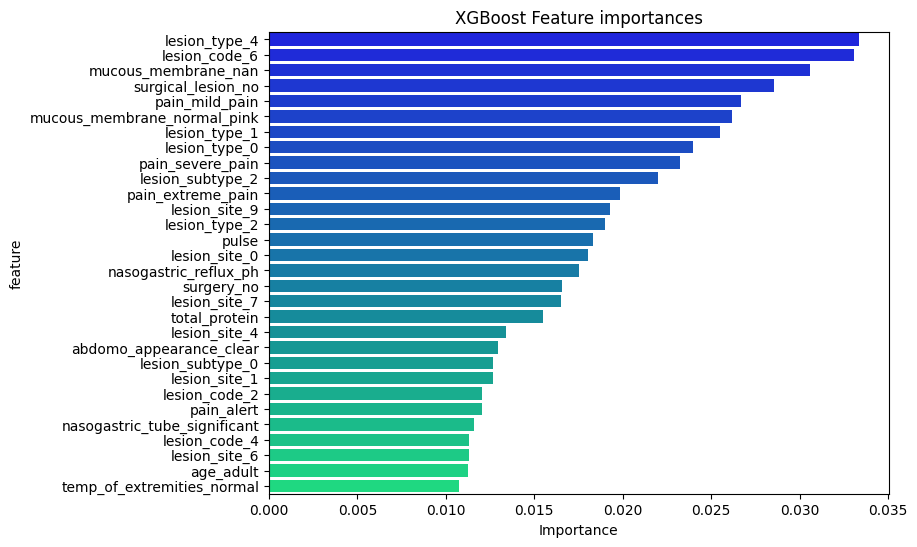

In [8]:
# Plot feature importances
feature_imp = pd.DataFrame({'feature': X_train.columns, 'Importance': xgb.feature_importances_}) 
feature_imp = feature_imp.sort_values('Importance', ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(data=feature_imp[:30], x='Importance', y='feature', palette='winter')
plt.title("XGBoost Feature importances")
plt.show()

In [9]:
feature_imp.shape

(115, 2)

In [10]:
# Evaluating models on different thresholds
def model_score():
    thresholds = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]
    models = {'xgb': XGBClassifier(random_state=24), 
               'lgbm': LGBMClassifier(random_state=24), 
               'cat': CatBoostClassifier(verbose=False, random_state=24)}
    for thresh in thresholds:
        imp_cols = feature_imp[feature_imp['Importance'] > thresh]['feature'].values.tolist()
        print(f"----------Model scores with {thresh} feature threshold----------")
        Xf = X[imp_cols]
    #     y = train['outcome'].map(({'died': 0,'lived': 1,'euthanized': 2}))
        X_train, X_test, y_train, y_test = train_test_split(Xf, y, test_size=0.1, stratify=y, random_state=24)
        Fscores = []
        for k, mod in models.items():
            mod.fit(X_train, y_train)
            y_preds = mod.predict(X_test)
            microF = f1_score(y_test, y_preds, average='micro')
#             print(f"MODEL: {k}")
#             print("Validation accuracy:", accuracy_score(y_test, y_preds))
#             print("Micro-averaged F1-Score:", microF)
            Fscores.append(microF)
#             print("*"*50)
        print(np.mean(Fscores))
model_score()

----------Model scores with 0.0 feature threshold----------
0.7510822510822511
----------Model scores with 0.001 feature threshold----------
0.7510822510822511
----------Model scores with 0.002 feature threshold----------
0.7337662337662337
----------Model scores with 0.003 feature threshold----------
0.7380952380952381
----------Model scores with 0.004 feature threshold----------
0.7467532467532467
----------Model scores with 0.005 feature threshold----------
0.7445887445887446
----------Model scores with 0.006 feature threshold----------
0.7424242424242423
----------Model scores with 0.007 feature threshold----------
0.7337662337662337
----------Model scores with 0.008 feature threshold----------
0.7445887445887446
----------Model scores with 0.009 feature threshold----------
0.7510822510822509
----------Model scores with 0.01 feature threshold----------
0.7510822510822509


In [11]:
features = feature_imp[feature_imp['Importance'] > 0.0]['feature'].values.tolist()
print(f"Number of important features: {len(features)}")
print(f"Number of uninformative features: {len(feature_imp)-len(features)}")

Number of important features: 96
Number of uninformative features: 19


### Modeling with selected features

I will be doing stratified split with 9 folds so that 11% data can be used for validation. This is done to replicate the behaviour of the Public LB because it also contains about 20% of the original test data which comes out to be 164 datapoints. Our training data data has 1534 datapoints and 11% roughly comes out to be around 168 which can give the feel of the public LB test data.

In [12]:
X = pd.get_dummies(train_df.drop(['outcome'], axis=1), dummy_na=True)
y = train['outcome'].map(({'died': 0,'lived': 1,'euthanized': 2}))
folds = 9
# Stratified split with 11% validation data in each split
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=24)
xgb_scores, lgbm_scores = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
#     X_train, y_train = X.iloc[train_idx][features], y.iloc[train_idx]
#     X_valid, y_valid = X.iloc[val_idx][features], y.iloc[val_idx]
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
    
    model_xgb = XGBClassifier()
    model_lgbm = LGBMClassifier()
    
    model_xgb.fit(X_train, y_train, verbose=False)
    model_lgbm.fit(X_train, y_train, verbose=False)
    
    val_preds_xgb = model_xgb.predict(X_valid)
    val_preds_lgbm = model_lgbm.predict(X_valid)
    
    F_score_xgb = f1_score(y_valid, val_preds_xgb, average='micro')
    F_score_lgbm = f1_score(y_valid, val_preds_lgbm, average='micro')
    xgb_scores.append(F_score_xgb)
    lgbm_scores.append(F_score_lgbm)
    
    print(f"------FOLD {fold+1}------")
    print("XGBoost score:", F_score_xgb)
    print("LGBM score:", F_score_lgbm)
    
print("\nMean F-score for XGBoost")
print(str(np.mean(xgb_scores))+'+-'+str(np.std(xgb_scores)))
print("Mean F-score for LGBM")
print(str(np.mean(lgbm_scores))+'+-'+str(np.std(lgbm_scores)))
print("Combined mean score:", (np.mean(xgb_scores)+np.mean(lgbm_scores))/2)

------FOLD 1------
XGBoost score: 0.7076023391812865
LGBM score: 0.7017543859649122
------FOLD 2------
XGBoost score: 0.7426900584795322
LGBM score: 0.7309941520467838
------FOLD 3------
XGBoost score: 0.8128654970760234
LGBM score: 0.7953216374269005
------FOLD 4------
XGBoost score: 0.783625730994152
LGBM score: 0.783625730994152
------FOLD 5------
XGBoost score: 0.7294117647058823
LGBM score: 0.7470588235294117
------FOLD 6------
XGBoost score: 0.7764705882352941
LGBM score: 0.7588235294117647
------FOLD 7------
XGBoost score: 0.6941176470588235
LGBM score: 0.6941176470588235
------FOLD 8------
XGBoost score: 0.7588235294117647
LGBM score: 0.7647058823529412
------FOLD 9------
XGBoost score: 0.7470588235294117
LGBM score: 0.7588235294117647

Mean F-score for XGBoost
0.7502962198524634+-0.03538184988919077
Mean F-score for LGBM
0.7483583686886061+-0.032236638509172306
Combined mean score: 0.7493272942705347


## Final predictions

In [13]:
final_feat = feature_imp[feature_imp['Importance'] > 0.0]['feature'].values.tolist()
X_final = pd.get_dummies(test_df, dummy_na=True)[final_feat]
xgb = XGBClassifier()
xgb.fit(X[final_feat], y)
preds = xgb.predict(X_final) 

## Submission

In [14]:
sub = pd.read_csv('/kaggle/input/playground-series-s3e22/sample_submission.csv')
sub['outcome'] = preds
sub['outcome'] = sub['outcome'].map({0: 'died', 1: 'lived', 2: 'euthanized'})
sub.to_csv("horse_submission.csv", index=False)

<div style="font-family: Verdana; background-color: #FFC09F; padding: 10px; border-radius: 5px; padding-top: 10px; padding-bottom: 2px; letter-spacing: 0.5px">
    <p> This notebook looks simple but a lot of time and effort has been gone in creating this solution. After succesive iterations and submissions, I have applied various feature engineering and selection techniques to come to this solution. Thanks for all the valuable discussions and notebooks contributed by the Kaggle community. Awesome work!!</p>
</div>